Connect to Google Sheets API

In [67]:
%pip install gspread oauth2client numpy matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 26.2/34.4 MB 820.0 kB/s eta 0:00:11
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/lib/python3/dist-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/lib/python3/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.10/http/client.py", line 465, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1130, in read
    return self._sslobj.read(len, buffer)
TimeoutError: The r

In [58]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# authorize the API client with the credentials
client = gspread.oauth()

# open the Google Sheets document by its URL or ID
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1eIdupjcWapVGPNMNTeKbnaPIroOXP6taFhrDMn5z3D4/edit#gid=1888658763')
# alternatively, you can open by the sheet ID only: client.open_by_key('your_sheet_id')

# get the worksheet by its name or index
worksheet = sheet.worksheet('2023_01_13_relative_5_1')
# alternatively, you can get by index: sheet.get_worksheet(0)

# fetch the data from the worksheet as a list of lists
data = worksheet.get_all_values()

mods = sheet.worksheet("Mods").get_all_values()

bivariate_raw = sheet.worksheet("Bivariate Analysis").get_all_values()

cmt3raw = sheet.worksheet("CMT3 Confirmation").get_all_values()
suvraw = sheet.worksheet("SUV Confirmation").get_all_values() 
wt_new_raw = sheet.worksheet("WT Confirmation").get_all_values()

D_dt_raw = sheet.worksheet("D_dt").get_all_values()

meth_lvl_raw = sheet.worksheet("meth_lvl").get_all_values()

In [59]:
import numpy as np


headers, wt_pre = data[0], data[1:]
mods_headers, mod_pre = mods[0], mods[1:]
cmt3_headers, cmt3_pre = cmt3raw[0], cmt3raw[1:]
suv_headers, suv_pre = suvraw[0], suvraw[1:]
bivariate_headers, bivariate_pre = bivariate_raw[0], bivariate_raw[1:]
D_dt_headers, D_dt_pre = D_dt_raw[0], D_dt_raw[1:]
wt_new_headers, wt_new_pre = wt_new_raw[0], wt_new_raw[1:]


wt = np.array(wt_pre, dtype=np.float32)
mod = np.array(mod_pre, dtype=np.float32)
cmt3 = np.array(cmt3_pre, dtype=np.float32)
suv = np.array(suv_pre, dtype=np.float32)
bivariate = np.array(bivariate_pre, dtype=np.float32)
D_dt = np.array(D_dt_pre, dtype=np.float32)
wt_new = np.array(wt_new_pre, dtype=np.float32)
meth_lvl = [ meth_lvl_raw[i+1][7] for i in range(8)]

u = [i for i in range(-500, 0, 5)]
g=  [i for i in range(0, 1000, 10)]
d = [i for i in range(1000, 1500, 5)]

x = u + g + d


obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
pred = wt_new[:, wt_new_headers.index('pred_steady_state')]
alpha = wt_new[:, wt_new_headers.index('alpha')]
beta = wt_new[:, wt_new_headers.index('beta')]
alpha_ci_lower = wt_new[:, wt_new_headers.index("ci_alpha_0.025")]
alpha_ci_upper = wt_new[:, wt_new_headers.index("ci_alpha_0.975")]
beta_ci_lower = wt_new[:, wt_new_headers.index("ci_beta_0.025")]
beta_ci_upper = wt_new[:, wt_new_headers.index("ci_beta_0.975")]
cg_int = bivariate[:, bivariate_headers.index('CG Density')]
cg_density = cg_int * 100  / (3955 * 5314 * 14) # Division into 100 windows, Average gene length 3955 bp, Number of genes 5314, 14 separate WGBS samples
h2az = bivariate[:, bivariate_headers.index('H2AZ')]  / (5314 * 14)
# h2az_compressed = [sum(h2az[i:i+10]) for i in range(0, len(h2az), 10)]

In [60]:
from matplotlib import pyplot as plt
# from matplotlib import font_manager

# # font_path = font_manager.findfont('Calibri')
# # plt.rcParams.update({'font.family': 'Calibri',
# #                      'font.size': 12})

Figure 3 left
- A: Observed vs predicted steady state methylation in in WT
- B: Alpha and Beta in WT
- C: CG density & H2AZ in WT

All above each other, connected TSS and TTS


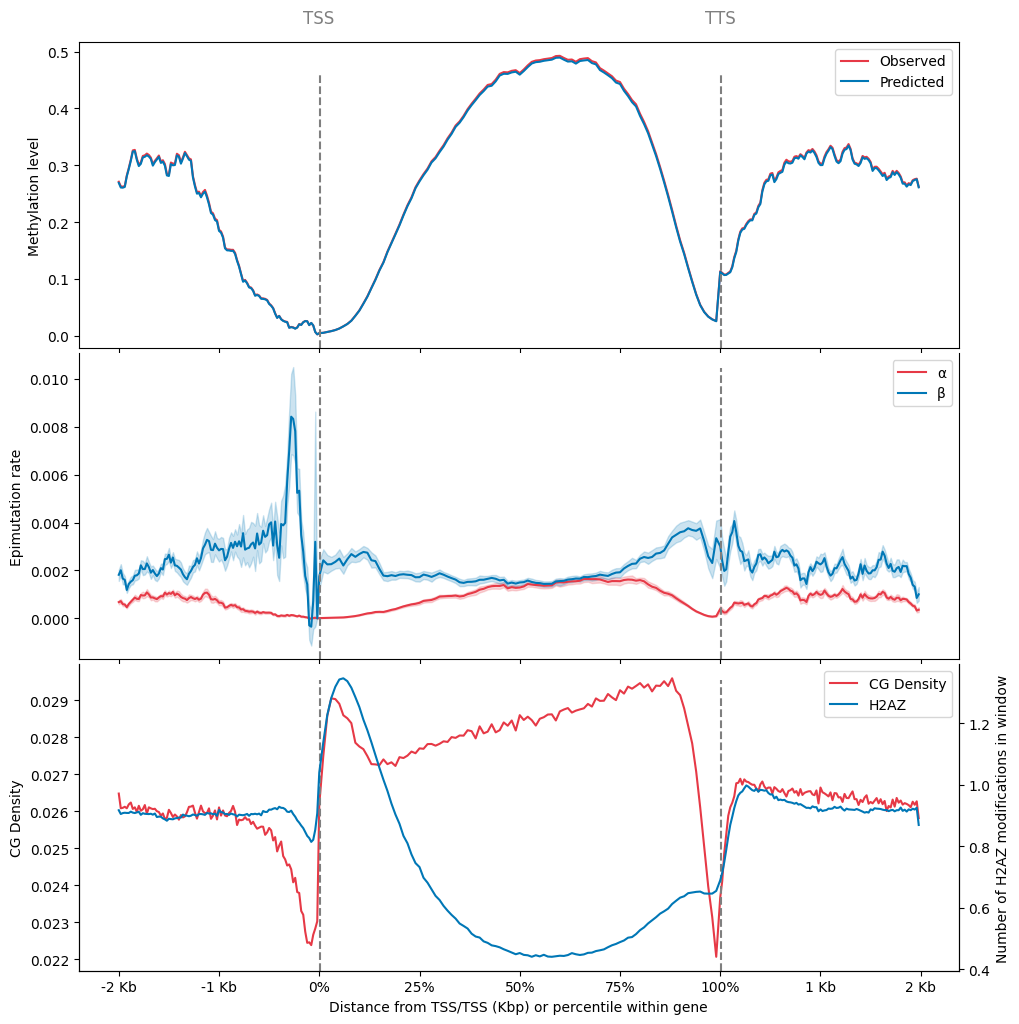

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1 ,sharex=True, figsize=(10,10)) 
ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis for H2AZ

r = "#e63946"
b = "#0077b6"

ax1.plot(x, obs, r, x, pred, b)
ax2.plot(x, alpha, r, x, beta, b)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, beta_ci_lower, beta_ci_upper, color=b, alpha=0.2)
c, = ax3.plot(x, cg_density, r, label='CG Density')
h, = ax4.plot(x, h2az, b, label='H2AZ')

def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
    
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
ax1.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-40, 0.55),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(962, 0.55),  color='C7', fontsize=12)
ax1.legend(['Observed', 'Predicted'], loc='upper right')
ax1.set_ylabel('Methylation level')



ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α', 'β'], loc='upper right')
ax2.set_ylabel("Epimutation rate")

ax3.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax3.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax3.legend([c,h],['CG Density', "H2AZ"], loc='upper right')
ax3.set_ylabel("CG Density")
ax3.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')
ax4.set_ylabel("Number of H2AZ modifications in window")


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines["top"].set_visible(False)



plt.savefig("3.png", dpi=120, bbox_inches="tight", pad_inches = 1)
plt.show()



Figure 4

- Comparison of wt, cmt3 and suv 

- Observed
- Alpha
- Beta

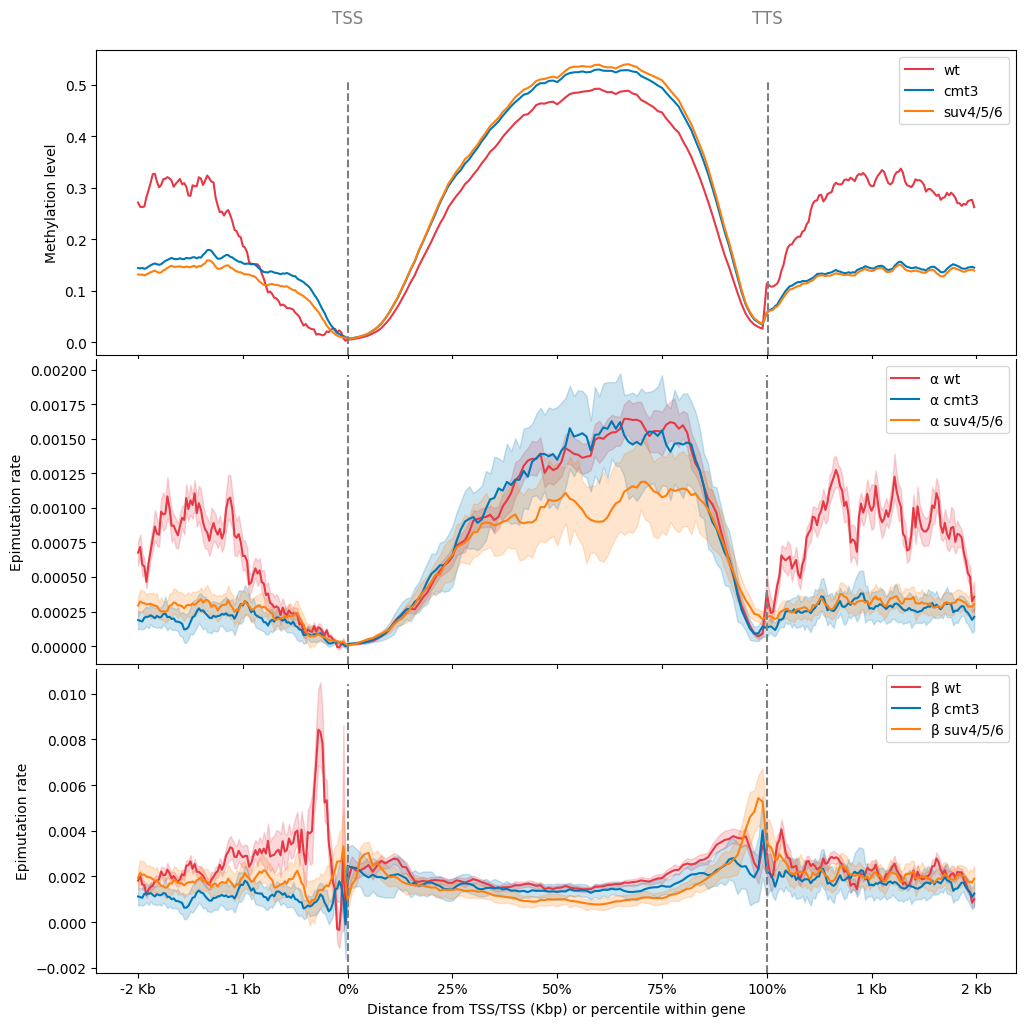

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1 ,sharex=True, figsize=(10,10)) 

r = "#e63946"
b = "#0077b6"
o = "C1"

wt_obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
cmt_obs = cmt3[:, cmt3_headers.index('obs_steady_state')]
suv_obs = suv[:, suv_headers.index('obs_steady_state')]

cmt_alpha = cmt3[:, cmt3_headers.index('alpha')]
cmt_beta = cmt3[:, cmt3_headers.index('beta')]
cmt_alpha_ci_lower = cmt3[:, cmt3_headers.index("ci_alpha_0.025")]
cmt_alpha_ci_upper = cmt3[:, cmt3_headers.index("ci_alpha_0.975")]
cmt_beta_ci_lower = cmt3[:, cmt3_headers.index("ci_beta_0.025")]
cmt_beta_ci_upper = cmt3[:, cmt3_headers.index("ci_beta_0.975")]

suv_alpha = suv[:, suv_headers.index('alpha')]
suv_beta = suv[:, suv_headers.index('beta')]
suv_alpha_ci_lower = suv[:, suv_headers.index("ci_alpha_0.025")]
suv_alpha_ci_upper = suv[:, suv_headers.index("ci_alpha_0.975")]
suv_beta_ci_lower = suv[:, suv_headers.index("ci_beta_0.025")]
suv_beta_ci_upper = suv[:, suv_headers.index("ci_beta_0.975")]


def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    
ax1.plot(x, wt_obs, r, x, cmt_obs, b, x, suv_obs, o)
ax1.axvline(x=2,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1002, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-38, 0.62),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(965, 0.62),  color='C7', fontsize=12)
ax1.legend(['wt', 'cmt3', "suv4/5/6"], loc='upper right')
ax1.set_ylabel('Methylation level')



ax2.plot(x, alpha, r, x, cmt_alpha, b, x, suv_alpha, o)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, cmt_alpha_ci_lower, cmt_alpha_ci_upper, color=b, alpha=0.2)
ax2.fill_between(x, suv_alpha_ci_lower, suv_alpha_ci_upper, color=o, alpha=0.2)
ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α wt', 'α cmt3' , "α suv4/5/6"], loc='upper right')
ax2.set_ylabel("Epimutation rate")

ax3.plot(x, beta, r, x, cmt_beta, b, x, suv_beta, o)
ax3.fill_between(x, beta_ci_lower, beta_ci_upper, color=r, alpha=0.2)
ax3.fill_between(x, cmt_beta_ci_lower, cmt_beta_ci_upper, color=b, alpha=0.2)
ax3.fill_between(x, suv_beta_ci_lower, suv_beta_ci_upper, color=o, alpha=0.2)
ax3.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax3.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax3.legend(['β wt', "β cmt3", "β suv4/5/6"], loc='upper right')
ax3.set_ylabel("Epimutation rate")
ax3.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')
ax4.set_ylabel("Number of H2AZ modifications in window")


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines["top"].set_visible(False)



plt.savefig("4.png", dpi=450)
plt.show()



Figure 3 right

- $\alpha$ vs CG Density
- $\alpha$ vs H2AZ

Show dotplot and lowess line

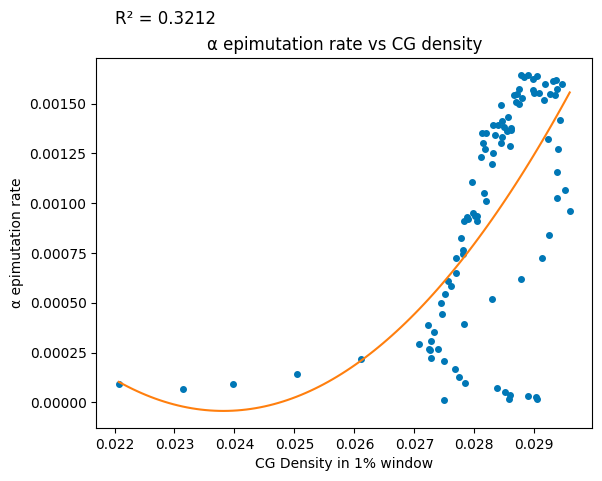

In [63]:
intragenic_cg_density = cg_density[101:200] 
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_cg_density, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_cg_density, intragenic_alpha, 2)
x = np.linspace(min(intragenic_cg_density), max(intragenic_cg_density), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs CG density")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(0.022, 0.0019, f"R² = 0.3212", fontsize=12)
plt.xlabel("CG Density in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_D.png", dpi=450, ) # TODO: alpha label not readable
plt.show()


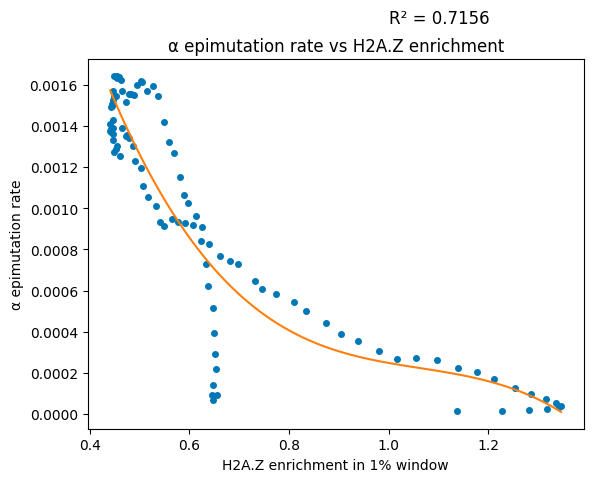

In [64]:
intragenic_h2az = h2az[101:200]
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_h2az, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_h2az, intragenic_alpha, 3)
x = np.linspace(min(intragenic_h2az), max(intragenic_h2az), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs H2A.Z enrichment")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(1, 0.0019, f"R² = 0.7156", fontsize=12)
plt.xlabel("H2A.Z enrichment in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_E.png", dpi=450) # TODO: alpha label not readable
plt.show()

Column Chart for Steady State

['0.2593456922', '0.2462442694', '0.2525945849', '0.2549897002', '0.2515528465', '0.2625954345', '0.2627126978', '0.2607703758']


/tmp/ipykernel_11385/35137546.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(gens)


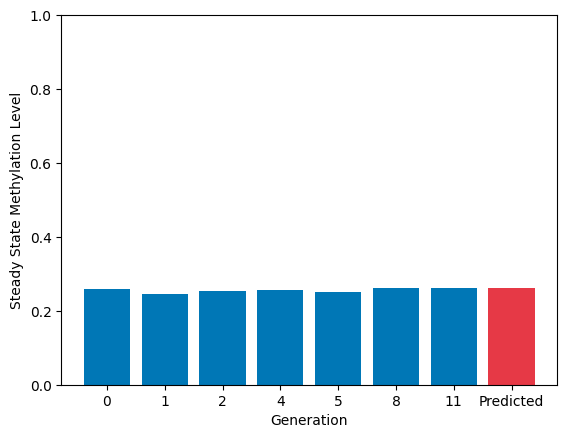

In [65]:

gens = ['', 0,1,2,4,5,8,11, "Predicted"]

# Generate some random data
data = np.random.randint(1, 10, 8)
print(meth_lvl)
# Create a figure and axes objects
fig, ax = plt.subplots()

# Create a list of colors for the columns
colors = [b] * 7 + [r] 

# Create the bar chart with custom colors
ax.bar(range(8), np.array(meth_lvl, dtype=np.float32), color=colors)

# Set the x-axis tick labels
ax.set_xticklabels(gens)
ax.set_ybound(0.0, 1.0)

# Set the title and axis labels
ax.set_xlabel('Generation')
ax.set_ylabel('Steady State Methylation Level')

# Show the plot
plt.savefig("1C.png", dpi=450)
plt.show()



Divergence over time

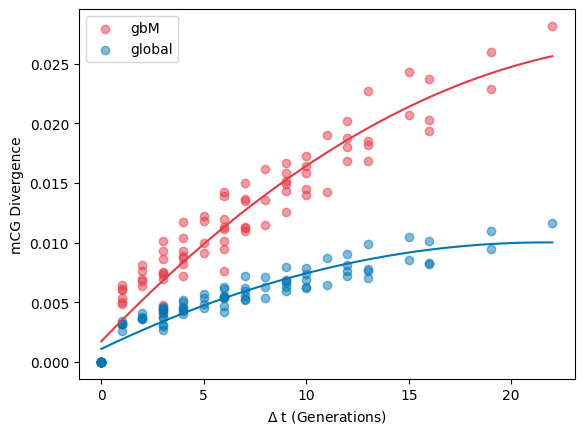

In [66]:
delta_t = D_dt[:,D_dt_headers.index("delta_t")]
D_gbM = D_dt[:,D_dt_headers.index("gbM")]
D_global = D_dt[:,D_dt_headers.index("all")]

delta_t = np.append(delta_t, [0,0,0,0,0,0,0,0,0,0,0,0,0,0])
D_gbM = np.append(D_gbM, [0,0,0,0,0,0,0,0,0,0,0,0,0,0])
D_global = np.append(D_global, [0,0,0,0,0,0,0,0,0,0,0,0,0,0])


fit_gbM = np.poly1d(np.polyfit(delta_t, D_gbM, 2))
fit_global = np.poly1d(np.polyfit(delta_t, D_global, 2))

x = np.linspace(min(delta_t), max(delta_t), num=100)



plt.scatter(delta_t, D_gbM, color=r, alpha=0.5, label="gbM")
plt.scatter(delta_t, D_global, color=b, alpha= 0.5, label = "global")
plt.legend()
plt.ylabel("mCG Divergence")
plt.xlabel("$\Delta$ t (Generations)")
plt.plot(x, fit_gbM(x), color=r)
plt.plot(x, fit_global(x), color=b)
plt.savefig("1D.png", dpi=450)
plt.show()
